# News Classifier - Reference implementation with GUI
**Jochen Connor Schäfer (jocsc896)**

Course 732A92 - Text Mining

Linköping University

17.01.2019

### Loading dependencies
The model requires pre-trained fastText-vectors to work properly. They can be retrieved from FacebookAI's website for 157 different languages: https://fasttext.cc/docs/en/crawl-vectors.html. Please download the German vectors and move the *wiki.de.vec* file into the subdirectory named *embeddings*.

In [1]:
import spacy
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
import pandas, xgboost, numpy, textblob, string, csv
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

/home/jochens/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/jochens/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preparing the environment

In [2]:
# Importing German language model
import de_core_news_sm
lng_model = de_core_news_sm.load()

** Defining progress bar. Widget taken from Alexander Kukushkin, https://github.com/alexanderkuk/log-progress **

Used under MIT-License

In [3]:

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

If the code below throws errors, try executing the following commands first
> nltk.download("punkt")
>
> nltk.download("stopwords")

In [5]:
title, date, content, label, orgshare, pershare, locshare, wordcount = [], [], [], [], [], [], [], []
sw =  set(stopwords.words('german'))
punct = r'!"§$%&/-()=?{[]}:,.\```\''
with open("articles.csv", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for row in log_progress(reader, every=1, size=13558):
        title.append(row[1])
        date.append(row[2])
        temp = row[3]
        word_tokens = nltk.word_tokenize(temp)
        filtered_sentence = [w for w in word_tokens if (not w in sw) and (not w in punct)]
        filtered_sentence = " ".join(filtered_sentence)
        content.append(filtered_sentence)
        nes = []
        for i in lng_model(row[3]).ents:
            nes.append(i.label_)
        wc = len(row[3].split())
        wordcount.append(wc)
        orgshare.append(nes.count("ORG")/wc)
        pershare.append(nes.count("PER")/wc)
        locshare.append(nes.count("LOC")/wc)
        label.append(row[4])

data = pandas.DataFrame()
data['title'] = title
data['date'] = date
data['text'] = content
data['label'] = label
data['wordcount'] = wordcount
data['orgshare'] = orgshare
data['locshare'] = locshare
data['pershare'] = pershare

VBox(children=(HTML(value=''), IntProgress(value=0, max=13558)))

In [ ]:
# Save corpus to disk
pickle.dump(data, open( "corpus_nosw.pck", "wb" ) )

## Checkpoint 1
If you have executed the above code before, you can restart here, thus avoiding the lenghty building of the corpus.

In [45]:
# Load corpus from disk
data = pickle.load( open( "corpus_nosw.pck", "rb" ) )

In [46]:
# Show descriptive statistics for complete data
data.describe()

,wordcount,orgshare,locshare,pershare
count,13638.000000,13638.000000,13638.000000,13638.000000
mean,463.332087,0.019023,0.025948,0.028527
std,396.678431,0.017915,0.018870,0.019746
min,5.000000,0.000000,0.000000,0.000000
25%,220.000000,0.006486,0.013083,0.013889
50%,374.000000,0.014314,0.022305,0.025271
75%,606.000000,0.026724,0.034571,0.040000
max,6076.000000,0.230769,0.213592,0.230769


In [48]:
# Drop examples with less than 100 words
minwords = data['wordcount'] >= 100
data = data[minwords]

In [49]:
# Show descriptive statistics for subset data
data.describe()

,wordcount,orgshare,locshare,pershare
count,12169.000000,12169.000000,12169.000000,12169.000000
mean,512.421070,0.017242,0.026205,0.027436
std,392.306351,0.014676,0.017653,0.017471
min,100.000000,0.000000,0.000000,0.000000
25%,278.000000,0.006443,0.013859,0.013921
50%,417.000000,0.013550,0.022556,0.024691
75%,645.000000,0.024768,0.034392,0.038710
max,6076.000000,0.161677,0.213592,0.124352


In [7]:
# Split in test and train data. Random state set for reproducile results 
train=data.sample(frac=0.8,random_state=42)
test=data.drop(train.index)

In [8]:
# Show descriptive statistics for training data
train.describe()

,wordcount,orgshare,locshare,pershare
count,9735.000000,9735.000000,9735.000000,9735.000000
mean,510.790960,0.017266,0.026148,0.027501
std,392.225923,0.014761,0.017701,0.017613
min,100.000000,0.000000,0.000000,0.000000
25%,277.000000,0.006341,0.013834,0.013889
50%,416.000000,0.013598,0.022436,0.024730
75%,643.000000,0.024953,0.034372,0.038726
max,6076.000000,0.161677,0.213592,0.124352


In [9]:
# Show descriptive statistics for validation data
test.describe()

,wordcount,orgshare,locshare,pershare
count,2434.000000,2434.000000,2434.000000,2434.000000
mean,518.940838,0.017148,0.026432,0.027173
std,392.640828,0.014335,0.017462,0.016892
min,100.000000,0.000000,0.000000,0.000000
25%,283.000000,0.006669,0.014038,0.014205
50%,420.500000,0.013405,0.022869,0.024547
75%,650.000000,0.023810,0.034454,0.038700
max,4480.000000,0.094650,0.142857,0.110000


In [51]:
# Show class distribution in validation data
print(test.label.value_counts())

politik       561
sport         525
wirtschaft    498
leute         259
panorama      244
ratgeber       95
wissen         83
auto           66
technik        65
leben          38
Name: label, dtype: int64


politik       2280
sport         2041
wirtschaft    1813
leute         1189
panorama       984
ratgeber       486
wissen         349
technik        238
auto           190
leben          165
Name: label, dtype: int64


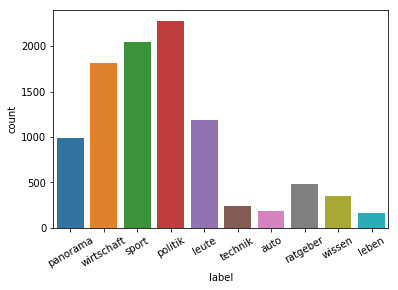

In [52]:
# Show and visualize class distribution in training data
import seaborn as sns
print(train.label.value_counts())
ax = sns.countplot(x="label", data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig = ax.get_figure()
fig.savefig('init_class_distr.png',dpi=160, bbox_inches="tight")

## Data Preprocessing

In [13]:
from sklearn.utils import resample
# Separate majority and minority classes
sport = train[train.label=="sport"]
politik = train[train.label=="politik"]
wirtschaft = train[train.label=="wirtschaft"]
panorama = train[train.label=="panorama"]
leute = train[train.label=="leute"]
auto = train[train.label=="auto"]
wissen = train[train.label=="wissen"]
technik = train[train.label=="technik"]
ratgeber = train[train.label=="ratgeber"]
leben = train[train.label=="leben"]

# Upsample minority class
sport = resample(sport, replace=True, n_samples=1000, random_state=4711)
politik = resample(politik, replace=True, n_samples=1000, random_state=4711)
leute = resample(leute, replace=True, n_samples=1000, random_state=4711)
wirtschaft = resample(wirtschaft, replace=True, n_samples=1000, random_state=4711)
ratgeber = resample(ratgeber, replace=True, n_samples=900, random_state=4711)
auto = resample(auto, replace=True, n_samples=350, random_state=4711)
panorama = resample(panorama, replace=True, n_samples=1000, random_state=4711)
wissen = resample(wissen, replace=True, n_samples=600, random_state=4711)
technik = resample(technik, replace=True, n_samples=450, random_state=4711)
leben = resample(leben, replace=True, n_samples=300, random_state=4711)
train_upsampled = pandas.concat([sport,politik,wirtschaft,panorama,leute,auto,wissen,technik,ratgeber,leben])

wirtschaft    1000
panorama      1000
politik       1000
sport         1000
leute         1000
ratgeber       900
wissen         600
technik        450
auto           350
leben          300
Name: label, dtype: int64


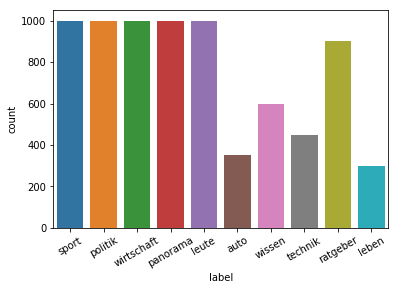

In [14]:
# Show and visualize class distribution for resampled data 
print(train_upsampled.label.value_counts())
lp = sns.countplot(x="label", data=train_upsampled)
lp.set_xticklabels(lp.get_xticklabels(),rotation=30)
fig = lp.get_figure()
fig.savefig('ups_class_distr.png',dpi=160, bbox_inches="tight")

In [15]:
# Extract predicition data and labels for training data
train_x = train_upsampled['text']
train_y = train_upsampled['label']
# Extract additional data
train_aux = train_upsampled.loc[:, ['orgshare', 'pershare','locshare']].as_matrix()

# Repeat aboove steps for test data
valid_x = test['text']
valid_y = test['label']
valid_aux = test.loc[:, ['orgshare', 'pershare','locshare']].as_matrix()


Note: Parts of the code below are inspired by the following blog article: https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

In [16]:
# Transform target values (labels/string) to categorical numerical data
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
dummy_train_y = np_utils.to_categorical(train_y)
dummy_valid_y = np_utils.to_categorical(valid_y)

In [18]:
# Import fast-text vectors
# Try-catch block used for skipping examples with faulty encoding
embeddings_index = {}
for i, line in enumerate(open('./embeddings/wiki.de.vec',encoding="utf-8")):
    values = line.split()
    try:
        embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')
    except ValueError:
        continue


In [19]:
# Create tokenizer
token = text.Tokenizer()
token.fit_on_texts(train['text'])
word_index = token.word_index

In [20]:
# Text is converted to sequence. Padding to ensure equal vector length of 700
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=700)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=700)

In [22]:
# Token-embedding-matrix
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
# Convolutional Neural Network, using Keras functional API
# Create Input layer. Dimensionality must correspond to length of text vectors.
input_layer = layers.Input((700, ))

# Word embedding layer
embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
# Dropout layer to avoid overfitting. => Optimizable Hyperparameter!
embedding_layer = layers.SpatialDropout1D(0.5)(embedding_layer)

# Convolutional Layer => Filter, Neighborhood size and activation function are optimizable hyperparameters!
conv_layer = layers.Convolution1D(100, 7, activation="relu")(embedding_layer)

# Pooling Layer
pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

# Add the auxiliary input for additional data. Dimensionality must correspond to the number of additional features.
auxiliary_input = layers.Input(shape=(3,), name='aux_input')
# Output Layer
output_layer1 = layers.concatenate([pooling_layer, auxiliary_input])
output_layer2 = layers.Dense(10, activation="sigmoid")(output_layer1)
# => Activation function is optimizable hyperparameter.

# Model compilation
model = models.Model(inputs=[input_layer,auxiliary_input], outputs=output_layer2)
sgd = optimizers.SGD(lr=0.1, momentum=0.8, decay=0.1/30)
# => Optimizer is optimizable hyperparameter.

# Define early stoping based on validation loss. Saves intermediate models, if val_loss is better than previous ones.
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint(filepath='best_model_nosw.h5', monitor='val_loss', save_best_only=True)]
model.compile(optimizer=sgd, loss='categorical_crossentropy')



## Network Training

** NOTE: ** If the code below has been executed before, you can skip the training and proceed with line 27.

In [26]:
# Training
history = model.fit([train_seq_x,train_aux], dummy_train_y, epochs=40, validation_data=([valid_seq_x,valid_aux],dummy_valid_y), callbacks=callbacks)

Train on 7600 samples, validate on 2434 samples
Epoch 1/40
7600/7600 [==============================] - 68s 9ms/step - loss: 1.7864 - val_loss: 1.0992
Epoch 2/40
7600/7600 [==============================] - 71s 9ms/step - loss: 0.9948 - val_loss: 0.4846
Epoch 3/40
7600/7600 [==============================] - 70s 9ms/step - loss: 0.4139 - val_loss: 0.4527
Epoch 4/40
7600/7600 [==============================] - 71s 9ms/step - loss: 0.2902 - val_loss: 0.4336
Epoch 5/40
7600/7600 [==============================] - 70s 9ms/step - loss: 0.2188 - val_loss: 0.3644
Epoch 6/40
7600/7600 [==============================] - 70s 9ms/step - loss: 0.1668 - val_loss: 0.3452
Epoch 7/40
7600/7600 [==============================] - 71s 9ms/step - loss: 0.1331 - val_loss: 0.3981
Epoch 8/40
7600/7600 [==============================] - 71s 9ms/step - loss: 0.1117 - val_loss: 0.3693
Epoch 9/40
7600/7600 [==============================] - 72s 9ms/step - loss: 0.1036 - val_loss: 0.3498
Epoch 10/40
7600/7600 [==

In [27]:
model.load_weights("best_model_nosw.h5")

In [28]:
# predict the labels on validation dataset
predictions = model.predict([valid_seq_x,valid_aux])    
predictions = predictions.argmax(axis=-1)

dict_keys(['val_loss', 'loss'])


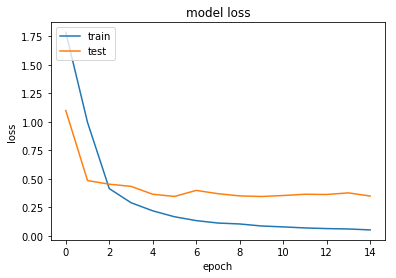

In [29]:
# visualize loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("modelloss.png",dpi=250)
plt.show()


## Model evaluation

** Confusion Matrix**

In [30]:
cm = metrics.confusion_matrix(valid_y, predictions)
cr = metrics.classification_report(valid_y, predictions)
# Standardize confusion matrix because of class imbalance
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
print(cm)

[[0.91 0.   0.   0.02 0.   0.   0.   0.   0.08 0.  ]
 [0.   0.42 0.29 0.16 0.03 0.03 0.   0.03 0.   0.05]
 [0.   0.   0.95 0.02 0.01 0.   0.01 0.   0.   0.  ]
 [0.   0.01 0.08 0.75 0.09 0.01 0.02 0.01 0.02 0.02]
 [0.   0.   0.01 0.05 0.86 0.   0.   0.   0.06 0.  ]
 [0.01 0.   0.01 0.02 0.   0.84 0.   0.01 0.07 0.03]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.   0.94 0.05 0.  ]
 [0.01 0.   0.   0.01 0.03 0.03 0.   0.01 0.92 0.  ]
 [0.01 0.01 0.   0.08 0.01 0.04 0.   0.01 0.02 0.81]]


** Precision, Recall and F1 per class **

In [31]:
print(cr)

             precision    recall  f1-score   support

          0       0.92      0.91      0.92        66
          1       0.80      0.42      0.55        38
          2       0.85      0.95      0.90       259
          3       0.76      0.75      0.75       244
          4       0.92      0.86      0.89       561
          5       0.78      0.84      0.81        95
          6       0.98      1.00      0.99       525
          7       0.85      0.94      0.89        65
          8       0.89      0.92      0.90       498
          9       0.85      0.81      0.83        83

avg / total       0.89      0.89      0.89      2434



** Visualization of Classification report **

Code provided by Franck Dernoncourt on StackOverflow: https://stackoverflow.com/a/34304414

In [32]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)
    class_names = ['auto', 'leben', 'leute', 'panorama', 'politik', 'ratgeber','sport', 'technik', 'wirtschaft', 'wissen']
    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

** Classification Report for Model **

[0.92, 0.91, 0.92]
[0.8, 0.42, 0.55]
[0.85, 0.95, 0.9]
[0.76, 0.75, 0.75]
[0.92, 0.86, 0.89]
[0.78, 0.84, 0.81]
[0.98, 1.0, 0.99]
[0.85, 0.94, 0.89]
[0.89, 0.92, 0.9]
[0.85, 0.81, 0.83]
plotMat: [[0.92, 0.91, 0.92], [0.8, 0.42, 0.55], [0.85, 0.95, 0.9], [0.76, 0.75, 0.75], [0.92, 0.86, 0.89], [0.78, 0.84, 0.81], [0.98, 1.0, 0.99], [0.85, 0.94, 0.89], [0.89, 0.92, 0.9], [0.85, 0.81, 0.83]]
support: [66, 38, 259, 244, 561, 95, 525, 65, 498, 83]


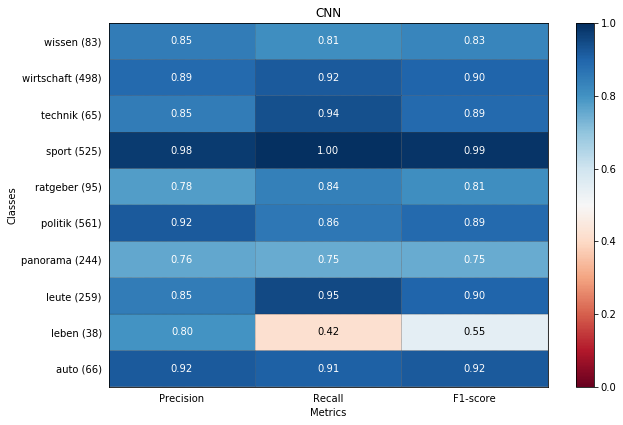

In [33]:
plot_classification_report(cr, title="CNN")
plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.show()
plt.close()

** Determining encoding of labels **

In [34]:
cm_lab = encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9])
cm_lab

/home/jochens/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['auto', 'leben', 'leute', 'panorama', 'politik', 'ratgeber',
       'sport', 'technik', 'wirtschaft', 'wissen'], dtype=object)

** Visualizaiton of normalized Confusion Matrix **

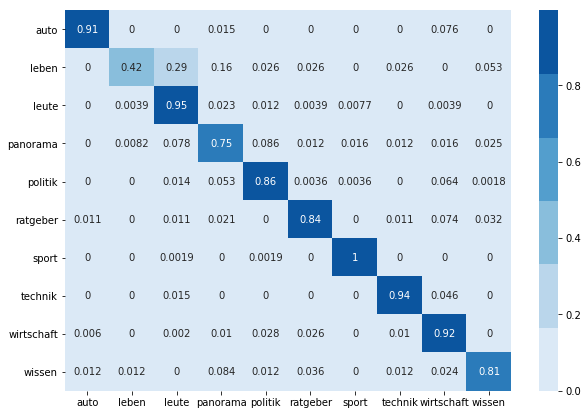

In [35]:
df_cm = pandas.DataFrame(cm, cm_lab,
                  columns = cm_lab)
plt.figure(figsize = (10,7))
cm_plot = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("Blues"))
cm_plot = cm_plot.get_figure()
cm_plot.savefig('confusion_matrix.png',dpi=160, bbox_inches="tight")

** Performance Metrics of the Model **

In [36]:
accuracy = metrics.accuracy_score(valid_y,predictions)
f1 = metrics.f1_score(valid_y,predictions, average=None)
f1_mi = metrics.f1_score(valid_y,predictions, average="micro")
f1_ma = metrics.f1_score(valid_y,predictions, average="macro")

print("Model:\nAccuracy:\t",  accuracy,"\nF1-Measure:\t",f1,"\nF1 micro:\t",f1_mi,"\nF1 macro:\t",f1_ma)

Model:
Accuracy:	 0.8927691043549713 
F1-Measure:	 [0.92 0.55 0.9  0.75 0.89 0.81 0.99 0.89 0.9  0.83] 
F1 micro:	 0.8927691043549713 
F1 macro:	 0.8426665688667931


## Baseline Models

In [55]:
# Random baseline
random = np.random.randint(low=0,high=10, size=len(valid_y))
rnd_accuracy = metrics.accuracy_score(valid_y,random)
rnd_f1 = metrics.f1_score(valid_y,random, average=None)
f1 = metrics.f1_score(valid_y,predictions, average=None)
f1_mi = metrics.f1_score(valid_y,random, average="micro")
f1_ma = metrics.f1_score(valid_y,random, average="macro")

print("Random Baseline:\nAccuracy:\t", rnd_accuracy,"\nF1-Measure:\t",f1,"\nF1 micro:\t",f1_mi,"\nF1 macro:\t",f1_ma)

Random Baseline:
Accuracy:	 0.0932621199671323 
F1-Measure:	 [0.92 0.55 0.9  0.75 0.89 0.81 0.99 0.89 0.9  0.83] 
F1 micro:	 0.0932621199671323 
F1 macro:	 0.07760496540184812


In [38]:
# Majority class baseline
majority = np.full((len(valid_y)), 4, dtype=int)
maj_accuracy = metrics.accuracy_score(valid_y,majority)
maj_f1 = metrics.f1_score(valid_y,majority, average=None)
f1_mi = metrics.f1_score(valid_y,majority, average="micro")
f1_ma = metrics.f1_score(valid_y,majority, average="macro")

print("Majority Baseline:\nAccuracy:\t",  maj_accuracy,"\nF1-Measure:\t",f1,"\nF1 micro:\t",f1_mi,"\nF1 macro:\t",f1_ma)

Majority Baseline:
Accuracy:	 0.2304847986852917 
F1-Measure:	 [0.92 0.55 0.9  0.75 0.89 0.81 0.99 0.89 0.9  0.83] 
F1 micro:	 0.2304847986852917 
F1 macro:	 0.03746243739565943


/home/jochens/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** Classification Report for baseline models **

In [39]:
cr_random = metrics.classification_report(valid_y, random)
cr_majority = metrics.classification_report(valid_y, majority)

/home/jochens/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.05, 0.18, 0.07]
[0.0, 0.03, 0.01]
[0.14, 0.13, 0.14]
[0.1, 0.09, 0.1]
[0.27, 0.12, 0.17]
[0.02, 0.05, 0.03]
[0.2, 0.1, 0.13]
[0.02, 0.09, 0.04]
[0.28, 0.14, 0.19]
[0.05, 0.13, 0.07]
plotMat: [[0.05, 0.18, 0.07], [0.0, 0.03, 0.01], [0.14, 0.13, 0.14], [0.1, 0.09, 0.1], [0.27, 0.12, 0.17], [0.02, 0.05, 0.03], [0.2, 0.1, 0.13], [0.02, 0.09, 0.04], [0.28, 0.14, 0.19], [0.05, 0.13, 0.07]]
support: [66, 38, 259, 244, 561, 95, 525, 65, 498, 83]


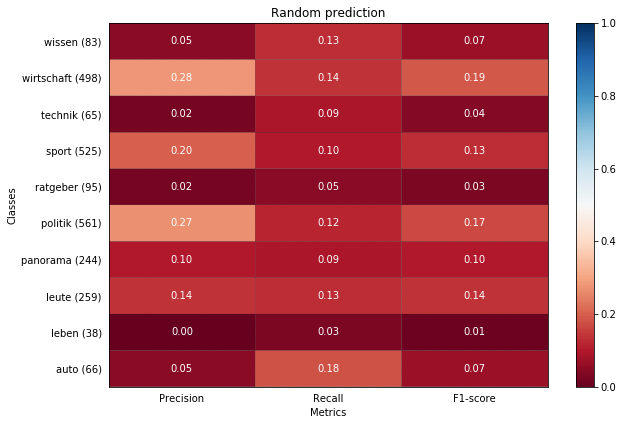

In [40]:
plot_classification_report(cr_random, title="Random prediction")
plt.savefig('cr_random.png', dpi=200, format='png', bbox_inches='tight')
plt.show()
plt.close()

[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.23, 1.0, 0.37]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
plotMat: [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.23, 1.0, 0.37], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
support: [66, 38, 259, 244, 561, 95, 525, 65, 498, 83]


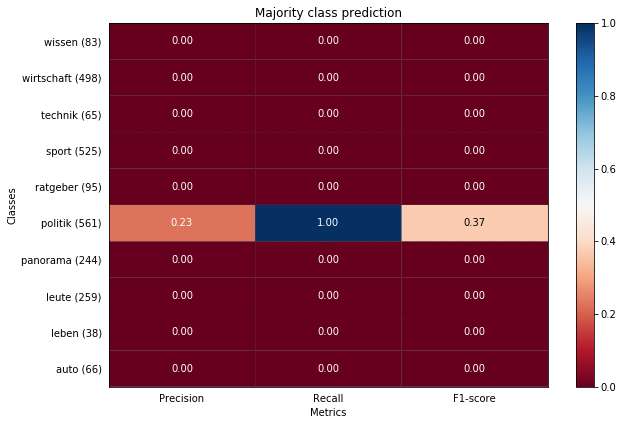

In [41]:
plot_classification_report(cr_majority, title="Majority class prediction")
plt.savefig('cr_majority.png', dpi=200, format='png', bbox_inches='tight')
plt.show()
plt.close()

## GUI

In [3]:
from tkinter import *

sw =  set(stopwords.words('german'))
punct = r'!"§$%&/-()=?{[]}:,.\```\''
class_decode = ['auto', 'leben', 'leute', 'panorama', 'politik', 'ratgeber',
       'sport', 'technik', 'wirtschaft', 'wissen']

root=Tk()
root.title("TopXtract Version: 0.0.2 Alpha")
def retrieve_input():
    sent_in=textBox.get("1.0","end-1c")
    word_tokens_class = nltk.word_tokenize(sent_in)
    fs_class = [w for w in word_tokens_class if (not w in sw) and (not w in punct)]
    fs_class = " ".join(fs_class)
    nes_class = []
    for i in lng_model(fs_class).ents:
        nes_class.append(i.label_)
    wc_class = len(fs_class.split())
    orgshare_class = (nes_class.count("ORG")/wc_class)
    pershare_class = (nes_class.count("PER")/wc_class)
    locshare_class = (nes_class.count("LOC")/wc_class)
    vc = sequence.pad_sequences(token.texts_to_sequences(pandas.Series(fs_class)), maxlen=700)
    class_aux = np.asarray([orgshare_class,pershare_class,locshare_class])
    class_aux = np.reshape(class_aux,(1,3))
    #class_aux = np.expand_dims(class_aux[0], axis=0)
    class_pred = model.predict([vc,class_aux],steps=1)    
    class_pred = class_pred.argmax(axis=-1)
    pred_label = class_decode[class_pred[0]]
    messagebox.showinfo("Result", "Your input was classified as belonging to:\n"+pred_label)

def about():
    messagebox.showinfo("About","TopXtract is experimental software indended for scientific purposes only. \nDo not use in productive environments.\n\n(c) 2019 - Jochen Schäfer\nUniversity of Linköping, Sweden")

textBox=Text(root, height=50, width=200)
textBox.pack()
buttonCommit=Button(root, height=1, width=10, text="Commit", 
                    command=lambda: retrieve_input())

buttonAbout=Button(root, height=1, width=10, text="About", 
                    command=lambda: about())
#command=lambda: retrieve_input() >>> just means do this when i press the button
buttonCommit.pack()
buttonAbout.pack()
mainloop()